In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Load and Preprocess Data

In [4]:
# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/Neural Network - Subodh sir/Week 5/GFCL -Nov25.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Neural Network - Subodh sir/Week 5/GFCLold.csv')

# Convert 'date' column to datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Set 'date' as the index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

# Select only numerical features for scaling
numerical_features = train_data.select_dtypes(include=np.number).columns.tolist()

# Get common numerical features between train and test data
common_numerical_features = list(set(numerical_features).intersection(test_data.columns))

# Normalize the numerical features using only the common features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[common_numerical_features]) # Scale only common numerical features
test_scaled = scaler.transform(test_data[common_numerical_features]) # Scale only common numerical features

# Convert scaled data back to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=common_numerical_features, index=train_data.index) # Use common features for columns
test_scaled = pd.DataFrame(test_scaled, columns=common_numerical_features, index=test_data.index) # Use common features for columns

# Create Sequences for RNN Input

In [5]:
def create_sequences(data, target_col, sequence_length):
    sequences = []
    targets = []
    data_values = data.values
    for i in range(len(data) - sequence_length):
        sequences.append(data_values[i : i + sequence_length])
        targets.append(data_values[i + sequence_length, target_col])
    return np.array(sequences), np.array(targets)

# Define sequence length and target column index
sequence_length = 30
target_col = 0  # meantemp is the target

# Create training sequences
X_train, y_train = create_sequences(train_scaled, target_col, sequence_length)

# Split training data into training and validation sets
split_idx = int(0.8 * len(X_train))
X_train_seq, X_val_seq = X_train[:split_idx], X_train[split_idx:]
y_train_seq, y_val_seq = y_train[:split_idx], y_train[split_idx:]

# Create test sequences
X_test, y_test = create_sequences(test_scaled, target_col, sequence_length)


# Define and Compile the RNN Model

In [6]:
# Define the RNN model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 4)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [7]:
# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32
)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0334 - val_loss: 0.0141
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0032 - val_loss: 0.0057
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0026 - val_loss: 0.0054
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0023 - val_loss: 0.0051
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0024 - val_loss: 0.0052
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0022 - val_loss: 0.0050
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0

# Evaluate and Predict

In [8]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual values for comparison
y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 3))], axis=1)
)[:, 0]

y_pred_actual = scaler.inverse_transform(
    np.concatenate([predictions, np.zeros((len(predictions), 3))], axis=1)
)[:, 0]

# Compare actual vs predicted values
comparison = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_pred_actual})
print(comparison.head())


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6519e-04
Test Loss: 0.0012293689651414752
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
   Actual   Predicted
0   132.0  133.477633
1   132.0  133.703331
2   132.0  133.936618
3   137.0  134.102985
4   135.0  134.323744


In [13]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
accuracy_percentage = 100 - (mape * 100)

print(f"Test Accuracy: {accuracy_percentage:.2f}%")

Test Accuracy: 95.54%


# Visualize Results

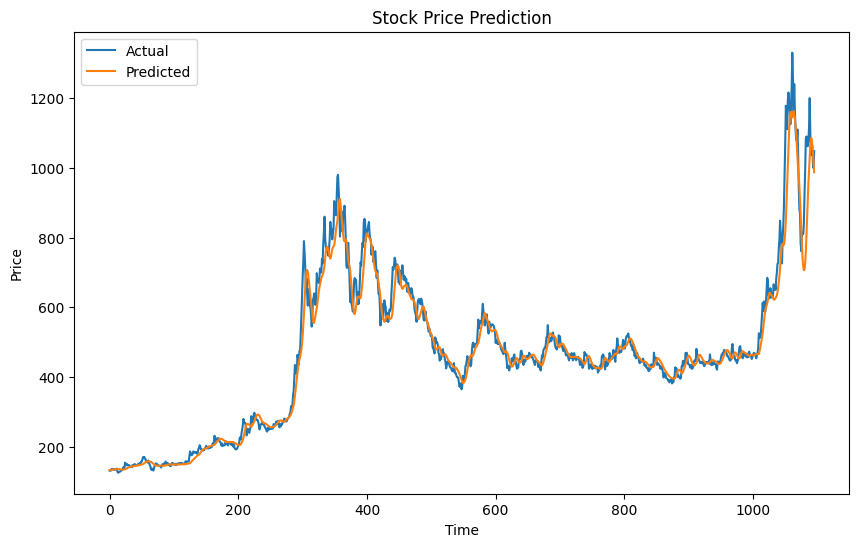

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()
